In [37]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    # tf.config.experimental.set_virtual_device_configuration(gpu_devices[0],
    # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
else:
    print('Using CPU')

sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [39]:
# UMCSENT - consumer sentiment data
# IPGMFN - Industrial production data
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2022-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516 entries, 1980-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  516 non-null    float64
 1   ip         516 non-null    float64
dtypes: float64(2)
memory usage: 12.1 KB


In [61]:
pd.concat([df.head(), df.tail()])

,sentiment,ip
DATE,,
1980-01-01,67.0,45.9070
1980-02-01,66.9,46.9873
1980-03-01,56.5,47.5088
1980-04-01,52.7,46.1199
1980-05-01,51.7,44.7920
2022-08-01,58.2,101.7727
2022-09-01,58.6,101.2498
2022-10-01,59.9,102.0855
2022-11-01,56.8,100.1035


In [41]:
# Stationarity
df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12), 'sentiment': df.sentiment.diff(12)}).dropna())
df_transformed.head(10)

,ip,sentiment
DATE,,
1981-01-01,-0.026729,4.4
1981-02-01,-0.030979,0.0
1981-03-01,-0.021237,10.0
1981-04-01,0.002605,19.7
1981-05-01,0.042682,24.6
1981-06-01,0.053847,14.4
1981-07-01,0.070643,11.8
1981-08-01,0.058296,9.9
1981-09-01,0.029441,-0.6


In [62]:
# Scaling to [0, 1] interval
df_transformed = df_transformed.apply(minmax_scale)
df_transformed.tail(10)

,ip,sentiment
DATE,,
2022-03-01,0.642062,0.153374
2022-04-01,0.617846,0.190184
2022-05-01,0.608759,0.168712
2022-06-01,0.599388,0.000000
2022-07-01,0.582802,0.088957
2022-08-01,0.591670,0.358896
2022-09-01,0.627843,0.326687
2022-10-01,0.590367,0.363497
2022-11-01,0.551657,0.381902


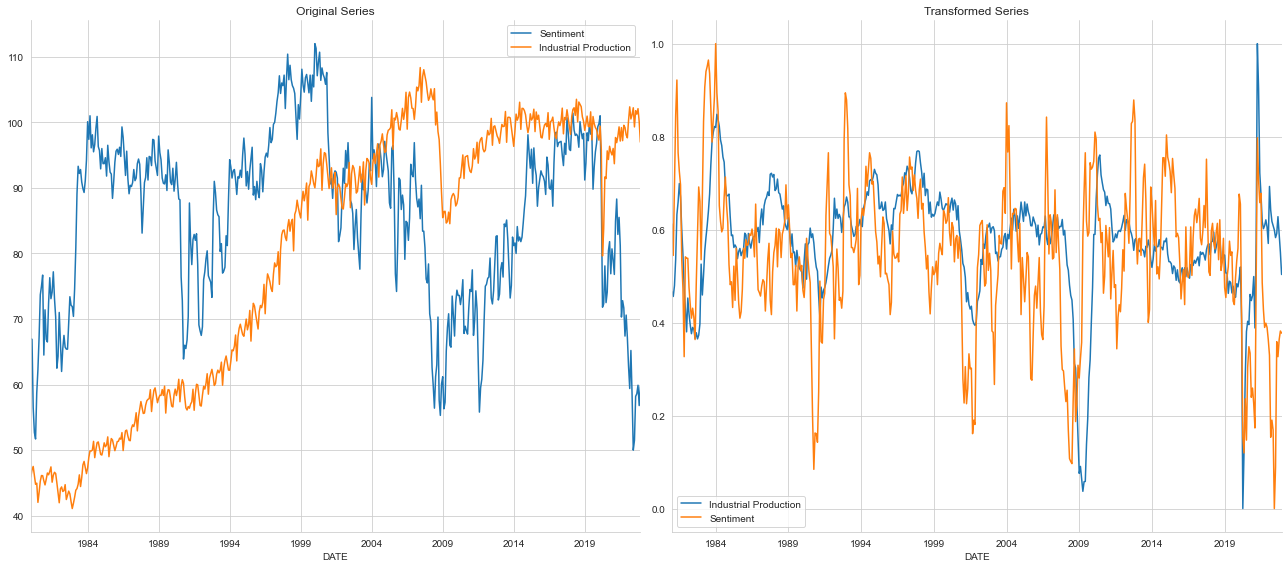

In [43]:
# Plot original and transformed series
fig, axes = plt.subplots(ncols=2, figsize=(18,8))
columns={'ip': 'Industrial Production', 'sentiment': 'Sentiment'}
df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Transformed Series')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'multi_rnn', dpi=300)

In [44]:
df.tail()

,sentiment,ip
DATE,,
2022-08-01,58.2,101.7727
2022-09-01,58.6,101.2498
2022-10-01,59.9,102.0855
2022-11-01,56.8,100.1035
2022-12-01,59.7,96.9749


In [45]:
# Reshape data into RNN format
df.values.reshape(-1, 12, 2).shape

(43, 12, 2)

In [46]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [47]:
window_size = 18 # for lagged 18 months window size
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)
X.shape, y.shape

((486, 18, 2), (486, 2))

In [48]:
df_transformed.head()

,ip,sentiment
DATE,,
1981-01-01,0.466355,0.611963
1981-02-01,0.456195,0.544479
1981-03-01,0.479486,0.697853
1981-04-01,0.536486,0.846626
1981-05-01,0.632300,0.921779


In [49]:
test_size =24 # using the last 24 months to test out of sample performance
train_size = X.shape[0]-test_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
X_train.shape, X_test.shape

((462, 18, 2), (24, 18, 2))

In [50]:
# Define Model Architecture
K.clear_session()
n_features = output_size = 2
lstm_units = 12
dense_units = 6
rnn = Sequential([
                    LSTM(units=lstm_units, dropout=.1, recurrent_dropout=.1,
                         input_shape=(window_size, n_features), name='LSTM', return_sequences=False),
                    Dense(dense_units, name='FC'),
                    Dense(output_size, name='Output')
                ])

In [51]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 12)                720       
                                                                 
 FC (Dense)                  (None, 6)                 78        
                                                                 
 Output (Dense)              (None, 2)                 14        
                                                                 
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


In [52]:
rnn.compile(loss='mae', optimizer='RMSProp')

In [53]:
# Train the Model
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path, verbose=1, monitor='val_loss', mode='min',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
result = rnn.fit(X_train, y_train, epochs=100, batch_size=20, shuffle=False, validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer], verbose=1, workers=6)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.2132
Epoch 00001: val_loss improved from inf to 0.12554, saving model to results/multivariate_time_series\lstm.h5
24/24 [==============================] - 7s 95ms/step - loss: 0.2132 - val_loss: 0.1255
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.0889
Epoch 00002: val_loss did not improve from 0.12554
24/24 [==============================] - 2s 63ms/step - loss: 0.0889 - val_loss: 0.1378
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.0870
Epoch 00003: val_loss did not improve from 0.12554
24/24 [==============================] - 2s 64ms/step - loss: 0.0870 - val_loss: 0.1426
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.0845
Epoch 00004: val_loss improved from 0.12554 to 0.12154, saving model to results/multivariate_time_series\lstm.h5
24/24 [==============================] - 2s 66ms/step - loss: 0.0845 - val_loss: 0.1215
Epoch 5/100
24/24 [=

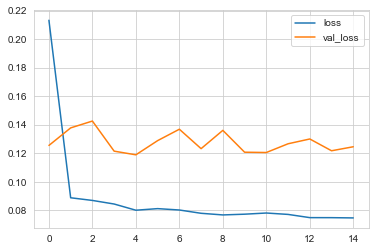

In [54]:
# Evaluate the Results
pd.DataFrame(result.history).plot();

In [55]:
y_pred = pd.DataFrame(rnn.predict(X_test), columns=y_test.columns, index=y_test.index)
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2021-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         24 non-null     float32
 1   sentiment  24 non-null     float32
dtypes: float32(2)
memory usage: 384.0 bytes


In [56]:
pd.concat([y_pred.head(), y_pred.tail()])

,ip,sentiment
DATE,,
2021-01-01,0.469613,0.318536
2021-02-01,0.474572,0.317582
2021-03-01,0.470207,0.301369
2021-04-01,0.476696,0.351042
2021-05-01,0.510296,0.444482
2022-08-01,0.566931,0.294177
2022-09-01,0.558592,0.327023
2022-10-01,0.555941,0.346962
2022-11-01,0.548618,0.367413


In [57]:
test_mae = mean_absolute_error(y_pred, y_test)
print(f'mean_absolute_error: "test_mae"')

mean_absolute_error: "test_mae"


In [58]:
y_test.index

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

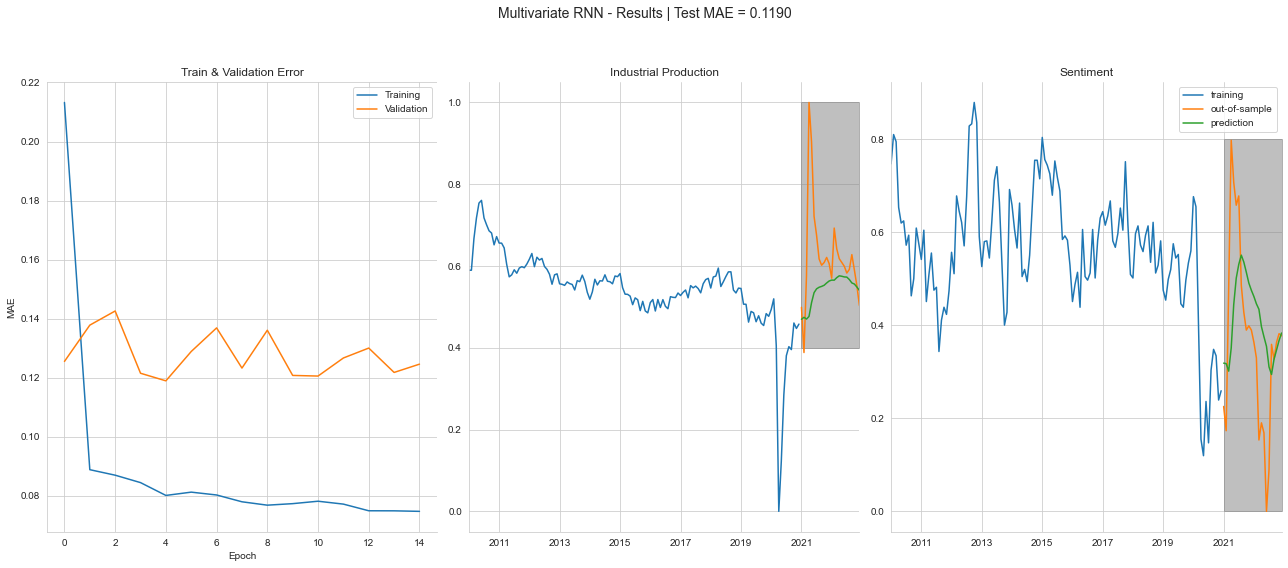

In [74]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 8))
pd.DataFrame(result.history).rename(columns={'loss': 'Training',
                                              'val_loss': 'Validation'}).plot(ax=axes[0], title='Train & Validation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
col_dict = {'ip': 'Industrial Production', 'sentiment': 'Sentiment'}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2010':, col].plot(ax=axes[i], label='training', title=col_dict[col])
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')

# axes[1].set_ylim(0, 1)
axes[1].fill_between(x=y_test.index, y1=0.4, y2=1, color='grey', alpha=.5)

# axes[2].set_ylim(0, 1)
axes[2].fill_between(x=y_test.index, y1=0, y2=0.8, color='grey', alpha=.5)

plt.legend()
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'multivariate_results', dpi=300)

# mae of the TimeSeries/TS_VectorAR_MDL.ipynb was about 0.1362 Slightly improved result(0.1190 here's mae)